In [1]:
import numpy as np
import pandas as pd
import string
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Carregando os Dados e lendo os Dados

In [2]:
df = pd.read_csv('dataset/Sentimento/Sentiment.csv', usecols=[5,15])

In [3]:
df.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  13871 non-null  object
 1   text       13871 non-null  object
dtypes: object(2)
memory usage: 216.9+ KB


In [5]:
df = df[df.sentiment != 'Neutral']

Negative    8493
Positive    2236
Name: sentiment, dtype: int64


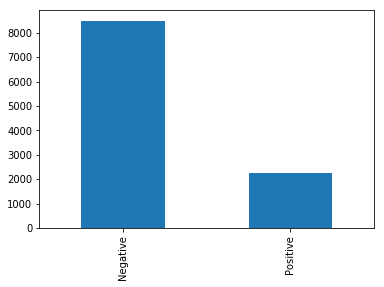

In [6]:
print(df.sentiment.value_counts())
df.sentiment.value_counts().plot(kind='bar')

In [7]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [8]:
df.isna().sum()

sentiment    0
text         0
dtype: int64

### Criando um dicionário para substituir as palavras contraídas 

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

### Limpeza
* Palavras em minuscula 
* Removendo rt do ínicio
* Substituindo as contrações
* Removendo caracteres especias

In [10]:
df.text = df.text.apply(lambda x: x.lower())
df.text = df.text.apply(lambda x: re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', x)) 
df.text = df.text.apply(lambda x: re.sub('(@[A-Za-z]+[A-za-z0-9-_]+)', '', x)) 
df.text = df.text.apply(lambda x: re.sub('rt', '', x)) 
df.text = df.text.apply(lambda x: re.sub('\<http.+?\>', '', x)) 
df.text = df.text.replace(regex=contraction_mapping) 
df.text = df.text.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
df.text = df.text.apply(lambda x: re.sub(' +', ' ', x)) 
df.head()

,sentiment,text
1,Positive,did not catch the full last night here are so...
3,Positive,that carly fiorina is trending hours after he...
4,Positive,w delivered the highest ratings in the histor...
5,Positive,on my first day i will rescind every illegal ...
6,Negative,i liked her and was happy when i heard she wa...


### Pegando o tamanho da maior setença

In [11]:
tm = []
for t in df.text:
    tm.append(len(t.split(' ')))
sentenca = np.max(tm)
print('Tamanho máximo da sentença: ', sentenca)

Tamanho máximo da sentença:  30


* Definindo o número de palavras do vocabulário
* Definindo o númeto de dimensões

In [12]:
max_palavra = 10000
embedding_dim = 20

### Gerando os tokens únicos com o máximo de palavras

In [13]:
tk = Tokenizer(num_words=max_palavra)
tk.fit_on_texts(df.text.values)
pl_unicas = tk.word_index
print('Quantidade de palavras únicas: ', len(pl_unicas)+1)

Quantidade de palavras únicas:  12099


In [14]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in tk.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if(value < thresh):
        cnt = cnt + 1
        freq = freq + value
    
print("% de palavras raras:",(cnt/tot_cnt)*100)
print("Total de palavras raras:",(freq/tot_freq)*100)
print('Palavras raras: ',cnt)
print('Tamanho do vocabulário: ',tot_cnt)
print('Palavras mais comuns: ', tot_cnt-cnt)

% de palavras raras: 76.84741279550339
Total de palavras raras: 7.976003209761752
Palavras raras:  9297
Tamanho do vocabulário:  12098
Palavras mais comuns:  2801


# Palavra usadas 

In [17]:
tk = Tokenizer(tot_cnt-cnt)
tk.fit_on_texts(list(df.text))
pl_unicas = tk.word_index
print('Quantidade de palavras únicas: ', len(pl_unicas)+1)

Quantidade de palavras únicas:  12099


### Fazendo o padding

In [16]:
x = tk.texts_to_sequences(df.text.values)
x = pad_sequences(x, maxlen = sentenca, padding='post')
print('Quantidade de dados de x: ', x.shape)

Quantidade de dados de x:  (10729, 30)


### Preparando o target

In [17]:
y = pd.get_dummies(df.sentiment.values)
print('Quantidade de dados de y: ', y.shape)

Quantidade de dados de y:  (10729, 2)


### Dados de treino e teste

In [18]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, random_state=2)
print(x_treino.shape, y_treino.shape)
print(x_teste.shape, y_teste.shape)

(8583, 30) (8583, 2)
(2146, 30) (2146, 2)


In [19]:
model = Sequential()
model.add(Embedding(max_palavra, embedding_dim, input_length=x.shape[1]))
model.add(LSTM(256, activation='relu', return_sequences=True, dropout=0.25))
model.add(LSTM(128, activation='relu', return_sequences=True, dropout=0.25))
model.add(LSTM(128, activation='relu', return_sequences=True, dropout=0.25))
model.add(LSTM(64, activation='relu', dropout=0.25))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 20)            200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           283648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 861,890
Trainable params: 861,890
Non-trainable params: 0
________________________________________________

In [34]:
batch_size = 128

file = '/home/rafael/Documentos/0002-00.15-04-2020.h5'
parada = EarlyStopping(monitor='val_accuracy', mode='max',patience=20,  baseline=0.4, min_delta=.0001)
check = ModelCheckpoint(file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

modelo = model.fit(x_treino, y_treino, epochs=100, batch_size=batch_size, verbose=2,
                  validation_data=(x_teste, y_teste),callbacks=[check, parada])

Train on 8583 samples, validate on 2146 samples
Epoch 1/100
8583/8583 [==============================] - 4s 477us/step - loss: 0.4572 - accuracy: 0.8137 - val_loss: 17.6477 - val_accuracy: 0.7889

Epoch 00001: val_loss improved from inf to 17.64765, saving model to /home/rafael/Documentos/0002-00.15-04-2020.h5
Epoch 2/100
8583/8583 [==============================] - 4s 476us/step - loss: 0.3667 - accuracy: 0.8252 - val_loss: 22.9597 - val_accuracy: 0.7973

Epoch 00002: val_loss did not improve from 17.64765
Epoch 3/100
8583/8583 [==============================] - 4s 479us/step - loss: 0.6160 - accuracy: 0.8326 - val_loss: 1057.5890 - val_accuracy: 0.7996

Epoch 00003: val_loss did not improve from 17.64765
Epoch 4/100
8583/8583 [==============================] - 4s 474us/step - loss: 0.7577 - accuracy: 0.8349 - val_loss: 11.2714 - val_accuracy: 0.7982

Epoch 00004: val_loss improved from 17.64765 to 11.27138, saving model to /home/rafael/Documentos/0002-00.15-04-2020.h5
Epoch 5/100
858

In [35]:
loss, acc = model.evaluate(x_teste, y_teste, verbose=0)
print('Acurácia: %f' % (acc*100))

Acurácia: 79.403543


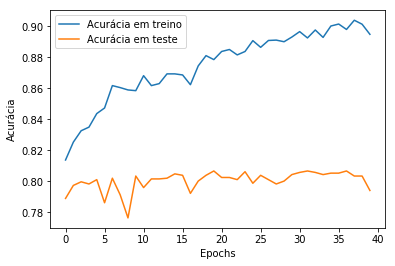

In [36]:
plt.plot(modelo.history['accuracy'])
plt.plot(modelo.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(['Acurácia em treino','Acurácia em teste'])
plt.show()

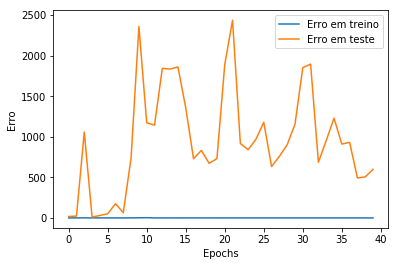

In [37]:
plt.plot(modelo.history['loss'])
plt.plot(modelo.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Erro')
plt.legend(['Erro em treino','Erro em teste'])
plt.show()